In [ ]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from customer_segmentation.utils import file_io, preprocessing, plot_utils

modules_to_reload = [file_io, preprocessing, plot_utils]
for module in modules_to_reload:
    importlib.reload(module)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [ ]:
cohort = file_io.read_or_write_csv(file_name="cohort_data.csv", to_read=True)

### **Preprocessing**

In [41]:
# convert data types
cohort["user_id"] = cohort["user_id"].astype(str)
cohort["cnt_trips"] = cohort["cnt_trips"].astype(int)
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])

**Explore distribution**

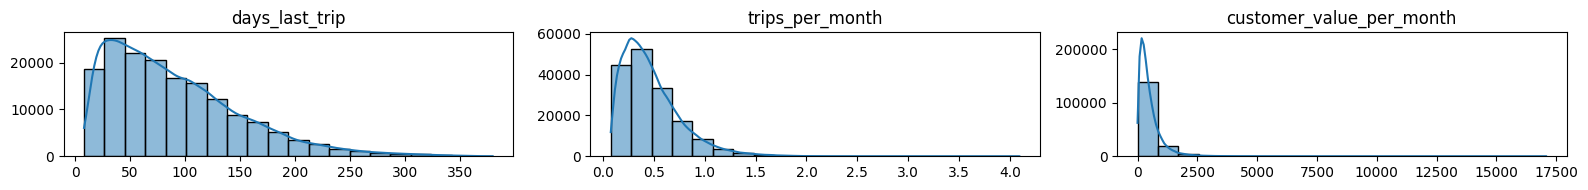

In [ ]:
metrics = ["days_last_trip", "trips_per_month", "customer_value_per_month"]

plot_utils.plot_univariate_series(
    df=cohort, metrics=metrics, n_cols=3, plot_type=sns.histplot
)

**Scaling metrics**
- For quantile-based scores, metrics will be log-transformed  
- For clustering analysis the metrics will also be scaled

In [43]:
features_log = {
    "recency_log": "days_last_trip",
    "frequency_log": "trips_per_month",
    "monetary_log": "customer_value_per_month",
}
X_log = np.log1p(cohort[list(features_log.values())])
cohort[list(features_log.keys())] = X_log

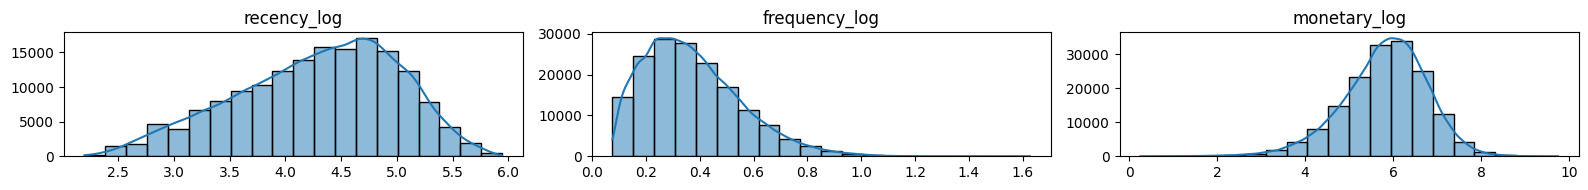

In [ ]:
plot_utils.plot_univariate_series(
    df=cohort, metrics=list(features_log.keys()), n_cols=3, plot_type=sns.histplot
)

In [45]:
features_scaled = {
    "recency_scaled": "days_last_trip",
    "frequency_scaled": "trips_per_month",
    "monetary_scaled": "customer_value_per_month",
}
scaler = StandardScaler()
X_log = np.log1p(cohort[list(features_scaled.values())])
X_scaled = scaler.fit_transform(X_log)
cohort[list(features_scaled.keys())] = X_scaled

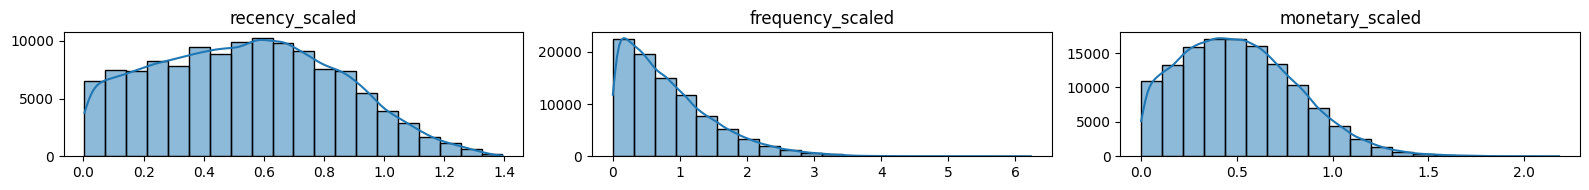

In [ ]:
plot_utils.plot_univariate_series(
    df=cohort, metrics=list(features_scaled.keys()), n_cols=3, plot_type=sns.histplot
)

### **RFM analysis**

**RFM scores based on quantiles**

In [47]:
# Recency: days_last_trip
# Frequency: trips_per_month
# Monetary: customer_value_per_month
# Tenure: time since first transaction (optional)

cohort["R_score"] = pd.qcut(cohort["recency_log"], q=5, labels=[5, 4, 3, 2, 1])
cohort["F_score"] = pd.qcut(cohort["frequency_log"], q=5, labels=[1, 2, 3, 4, 5])
cohort["M_score"] = pd.qcut(cohort["monetary_log"], q=5, labels=[1, 2, 3, 4, 5])

cohort["RFM_score"] = cohort[["R_score", "F_score", "M_score"]].astype(int).sum(axis=1)

In [48]:
conditions = [
    (cohort["RFM_score"] >= 13),
    (cohort["RFM_score"] >= 10) & (cohort["RFM_score"] < 13),
    (cohort["RFM_score"] >= 7) & (cohort["RFM_score"] < 10),
    (cohort["RFM_score"] >= 4) & (cohort["RFM_score"] < 7),
    (cohort["RFM_score"] < 4),
]

labels = [
    "Champions",
    "Loyal Customers",
    "Potential Loyalists",
    "At risk",
    "Lost",
]

cohort["RFM_groups"] = np.select(conditions, labels, default="Unknown")
cohort["RFM_groups"] = cohort["RFM_groups"].astype("category")
cohort["RFM_groups"] = cohort["RFM_groups"].cat.reorder_categories(labels, ordered=True)

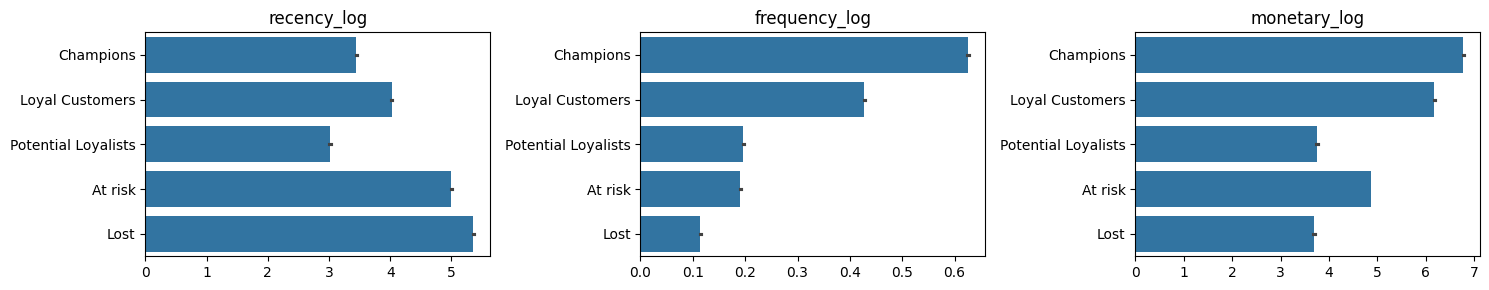

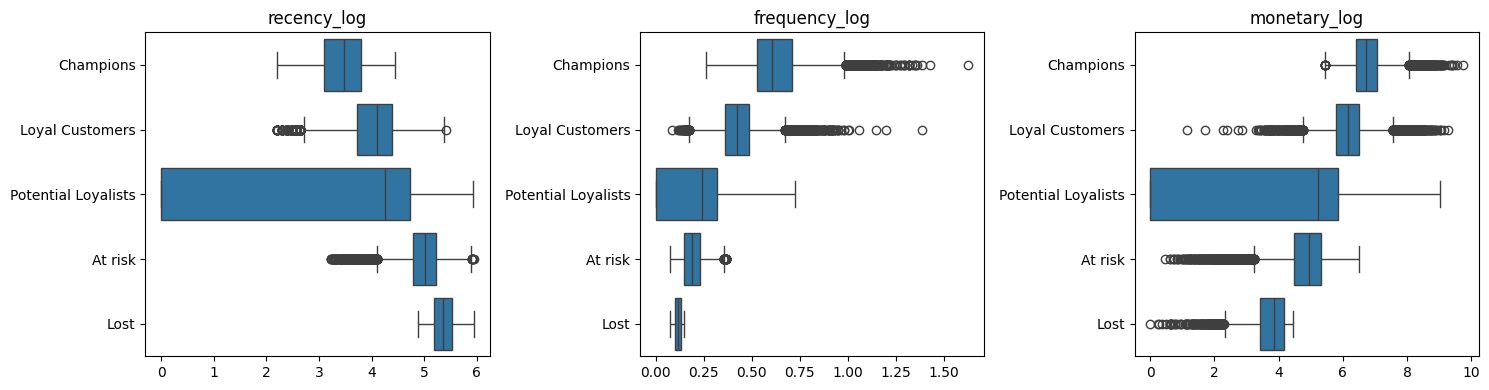

In [ ]:
plot_utils.plot_bivariate_series(
    df=cohort,
    category="RFM_groups",
    metrics=list(features_log.keys()),
    n_cols=3,
    plot_type=sns.barplot,
    swap_axes=True,
    fig_width=15,
    fig_height=3,
)
plot_utils.plot_bivariate_series(
    df=cohort,
    category="RFM_groups",
    metrics=list(features_log.keys()),
    n_cols=3,
    plot_type=sns.boxplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)

In [ ]:
cohort.groupby("RFM_groups", observed=True)[metrics].mean().round(
    1
).T.style.background_gradient(cmap="YlGnBu", axis=1).format("{:.1f}")

![RFM groups table](../images/rfm_groups_table.png?v2)

**RFM clustering**

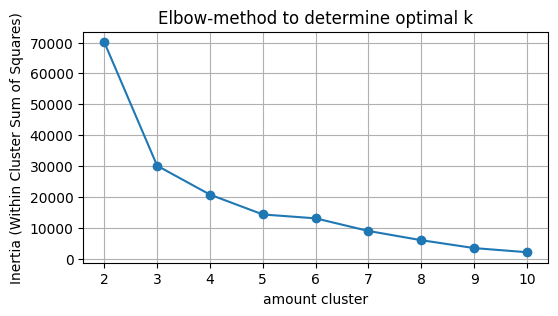

In [51]:
# estimate k cluster based on interia

X = cohort[list(features_scaled.keys())].astype(int)
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(6, 3))
plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

In [52]:
# Perform K-means clustering with best K
kmeans = KMeans(n_clusters=5, n_init=10, random_state=3)
cohort["RFM_cluster"] = kmeans.fit_predict(X)

In [53]:
cohort.groupby("RFM_cluster")[metrics].mean().round(2).T.style.background_gradient(
    cmap="YlGnBu", axis=0
).format("{:.2f}").set_properties(**{"font-size": "12px", "padding": "10px"})

RFM_cluster,0,1,2,3,4
days_last_trip,91.59,0.00,42.95,245.17,25.82
trips_per_month,0.38,0.00,0.86,0.17,1.34
customer_value_per_month,428.05,0.00,830.80,218.92,1168.33


In [56]:
labels = [
    "Champions",
    "Loyal Customers",
    "Potential Loyalists",
    "At-risk Customers",
    "Lost",
]
conditions = [
    (cohort["RFM_cluster"] == 4),
    (cohort["RFM_cluster"] == 2),
    (cohort["RFM_cluster"] == 0),
    (cohort["RFM_cluster"] == 3),
    (cohort["RFM_cluster"] == 1),
]

cohort["RFM_cluster_groups"] = np.select(conditions, labels, default="Unknown")
cohort["RFM_cluster_groups"] = cohort["RFM_cluster_groups"].astype("category")
cohort["RFM_cluster_groups"] = cohort["RFM_cluster_groups"].cat.reorder_categories(
    labels, ordered=True
)

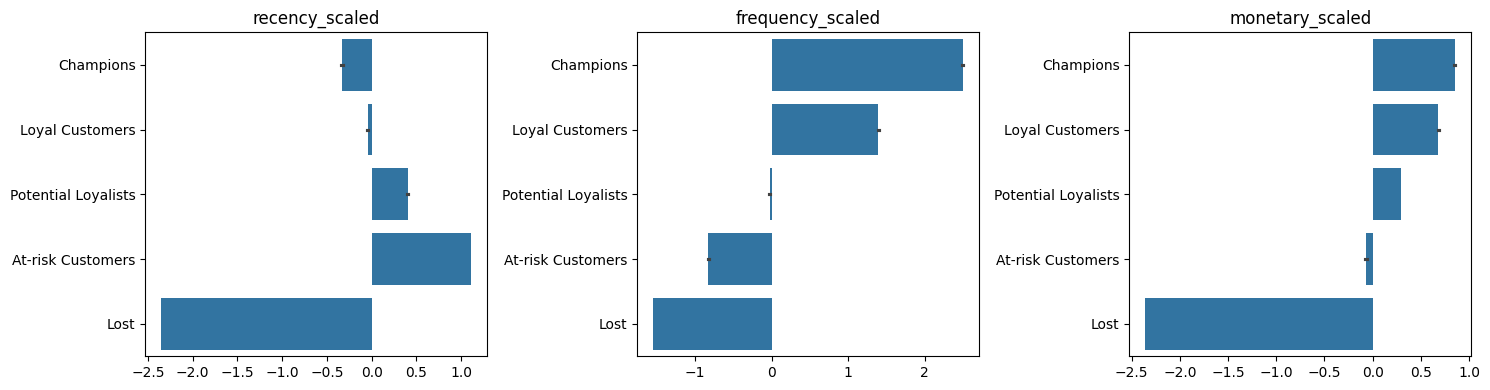

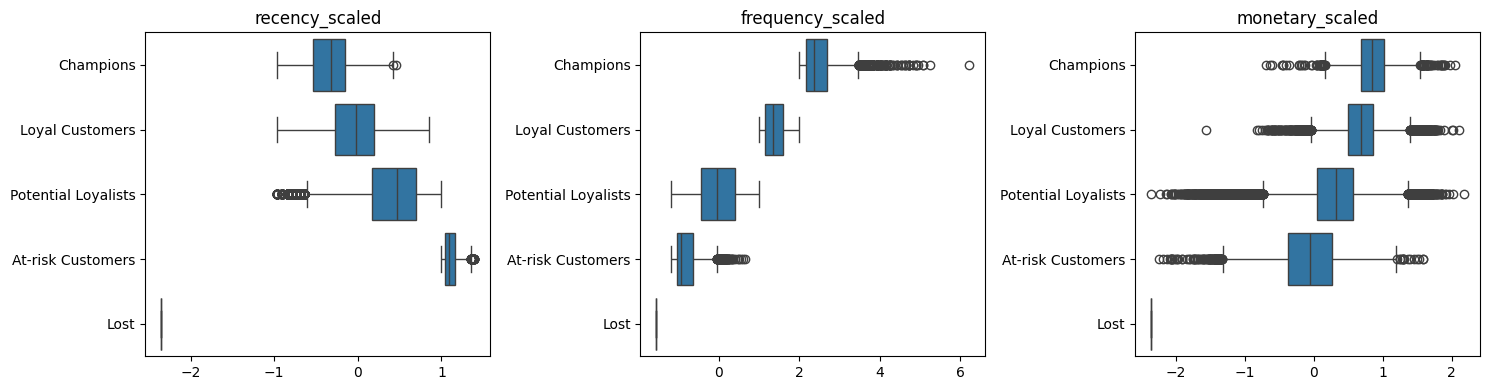

In [ ]:
plot_utils.plot_bivariate_series(
    df=cohort,
    category="RFM_cluster_groups",
    metrics=list(features_scaled.keys()),
    n_cols=3,
    plot_type=sns.barplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)
plot_utils.plot_bivariate_series(
    df=cohort,
    category="RFM_cluster_groups",
    metrics=list(features_scaled.keys()),
    n_cols=3,
    plot_type=sns.boxplot,
    swap_axes=True,
    fig_width=15,
    fig_height=4,
)

In [ ]:
cohort.groupby("RFM_cluster_groups", observed=True)[metrics].mean().round(
    1
).T.style.background_gradient(cmap="YlGnBu", axis=1).format("{:.1f}")

![RFM cluster groups table](../images/rfm_cluster_groups_table.png?v2)

### **Conclusion**
K-Means clustering identified a group of users who made no bookings at all, which were not captured by the quantile-based RFM approach.  
Unlike the fixed quantile method, clustering enables a more nuanced and flexible segmentation of users based on their RFM behavior.

**Export RFM results**

In [59]:
float_values = cohort.select_dtypes(include=float).columns.to_list()
cohort[float_values] = cohort[float_values].round(2)

In [61]:
cohort_subset = cohort[["user_id", "RFM_cluster_groups", "RFM_groups"]]

In [ ]:
file_io.read_or_write_csv(df=cohort_subset, file_name="RFM_analysis_results.csv")